In [22]:
from ortools.sat.python import cp_model
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [23]:
job_durations = [4, 3, 2, 5]
num_jobs = len(job_durations)
num_workers = 3
workers_times = [6, 8, 5]

In [24]:
# Create the model
model = cp_model.CpModel()

# Create variables
jobs = [model.new_int_var(0, 2, f'j{i}') for i in range(num_jobs)] #j0, j1, j2, j3

In [25]:
# constraint 1: j1 and j0 cannot be assigned to same worker
model.add(jobs[0] != jobs[1]) #j1 != j2

# constraint 2 & 3: 2 jobs per worker within their time limit
for w in range(num_workers):
    job_count = [model.new_bool_var(f'j{i}_is_W{w}') for i in range(num_jobs)] #list of jobs status for each worker(ether job is assigned to worker or not)
    for j in range(num_jobs):
        model.add(jobs[j] == w).only_enforce_if(job_count[j])
        model.add(jobs[j] != w).only_enforce_if(job_count[j].Not())

    model.add(sum(job_count) <= 2) #each worker can only do 2 jobs

    model.add(sum(job_durations[j] * job_count[j] for j in range(num_jobs)) <= workers_times[w]) #each worker can only do jobs within their time limit

# minimize any of the workers time
worker_load = []
for w in range(num_workers):
    load = model.new_int_var(0, sum(job_durations), f'load_W{w}')
    selected = []
    for i in range(len(job_count)):
        is_assigned = model.new_bool_var(f'j{i}_is_W{w}')
        model.add(jobs[i] == w).only_enforce_if(is_assigned)
        model.add(jobs[i] != w).only_enforce_if(is_assigned.Not())
        selected.append(is_assigned * job_durations[i])
    model.add(load == sum(selected))
    worker_load.append(load)

max_load = model.new_int_var(0, sum(job_durations), 'max_load')
model.add_max_equality(max_load, worker_load) #max load of all workers
model.Minimize(max_load) #minimize the max load of all workers

In [26]:
#but it will not give all solutions becasue we are maximizing the load of workers.
# Custom solution printer to print all solutions
class JobAssignmentPrinter(cp_model.CpSolverSolutionCallback):
    def __init__(self, jobs, max_load):
        cp_model.CpSolverSolutionCallback.__init__(self)
        self._jobs = jobs
        self._max_load = max_load
        self._solution_count = 0

    def on_solution_callback(self):
        self._solution_count += 1

        # Collect job assignments
        assignments = [self.Value(self._jobs[j]) for j in range(len(self._jobs))]

        print(f'Solution {self._solution_count}:')
        for j in range(len(self._jobs)):
            print(f'  Job J{j + 1} assigned to Worker W{self.Value(self._jobs[j]) + 1}')
        print(f'  Max load: {self.Value(self._max_load)}\n')

        plot_solution(assignments, job_durations, self._solution_count)

    def solution_count(self):
        return self._solution_count

In [27]:
def plot_solution(assignments, durations, solution_num):
    fig, ax = plt.subplots()
    colors = ['skyblue', 'lightgreen', 'salmon', 'plum']
    job_labels = []

    for w in range(num_workers):
        current_time = 0
        for j, assigned_worker in enumerate(assignments):
            if assigned_worker == w:
                ax.broken_barh([(current_time, durations[j])], (w * 10, 9),
                               facecolors=colors[j % len(colors)])
                ax.text(current_time + durations[j]/2, w * 10 + 4.5, f'J{j+1}',
                        va='center', ha='center', color='black')
                current_time += durations[j]
    ax.set_ylim(0, num_workers * 10)
    ax.set_xlim(0, max(sum(job_durations), max(workers_times)) + 2)
    ax.set_xlabel('Time')
    ax.set_yticks([i * 10 + 4.5 for i in range(num_workers)])
    ax.set_yticklabels([f'Worker W{i+1}' for i in range(num_workers)])
    ax.set_title(f'Solution {solution_num}')
    plt.tight_layout()
    plt.show()

Solution 1:
  Job J1 assigned to Worker W2
  Job J2 assigned to Worker W3
  Job J3 assigned to Worker W3
  Job J4 assigned to Worker W1
  Max load: 5



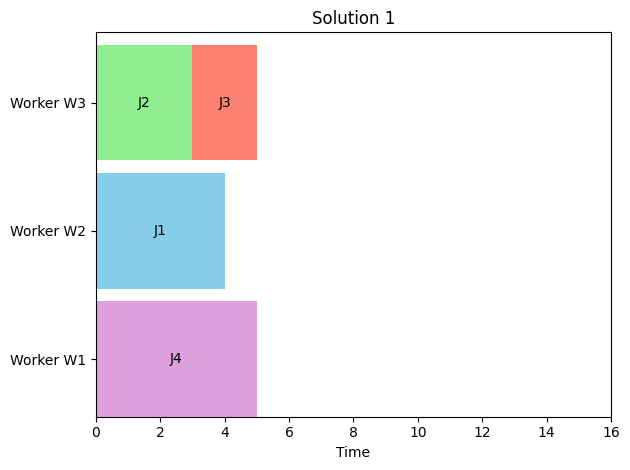

Total solutions found: 1


In [28]:
# Solve and enumerate all solutions
solver = cp_model.CpSolver()
solution_printer = JobAssignmentPrinter(jobs, max_load)
solver.parameters.enumerate_all_solutions = True
status = solver.Solve(model, solution_printer)

print(f'Total solutions found: {solution_printer.solution_count()}')